In [1]:
#####################################################################
# This notebook is authored by: Ayan Paul & Lina Alasfar            #
# Date: May 2022                                                    #
# If you use this code or the results from this work please cite:   # 
# Machine learning the trilinear and light-quark Yukawa couplings   #
# from Higgs pair kinematic shapes                                  #
# Lina Alasfar, Ramona Gröber, Christophe Grojean, Ayan Paul        #
# and Zuoni Qian                                                    #
# arXiv:2207.04157 (https://arxiv.org/abs/2207.04157)               #  
#####################################################################

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import os
import math as m
import collections
import pickle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from colour import Color
from matplotlib import rc
import sys
import time
from joblib import Parallel, delayed

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'monospace'

# To supress warnings from shap
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

N_THREADS = 25 ## Change for reducing load on CPU
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
seed = 42

colors = ['#3f7f93','#da3b46']
cmp_2 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#98b83b']
cmp_3 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#F6AE2D', '#98b83b']
cmp_4 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#F6AE2D', '#98b83b', '#825FC3']
cmp_5 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#60a0af', '#af6079', '#a8b96f', '#fcb880', '#FDD7D0', '#a5d6e0']
cmp_6 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#60a0af', '#af6079', '#a8b96f', '#fcb880', '#FDD7D0', '#a5d6e0', '#825FC3']
cmp_7 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

# how far in eta the endcap goes
ENDCAP = 4

In [2]:
def fileparser(path, dlist, sclass, sample, L=2, cut=False):
    """ The fileparser to read the events from a csv
        argument:
            path: the path to the file
            dlist: the list of variables to be excluded
            sample: the number of events that will be the train sample.
            L: Luminosity scaling
        returns:
            df_train: the training dataframe
            df_test: the testing dataframe
            weight: the weight (related to crosssection)
    """
    df = pd.read_csv(path)
    
    n = len(df)
    df['class'] = sclass
    weight = int(round(np.abs(df['weight'].sum()) * 3. * 1e6 * L)) ## The abs(mean()) is taken to make the weight of ybyt +ve
    if cut: 
        N_cut = df.drop(df[((np.abs(df['etaa1'])>ENDCAP) | (np.abs(df['etaa2'])>ENDCAP) | (np.abs(df['etab1'])>ENDCAP) | (np.abs(df['etab2'])>ENDCAP))].index).shape[0]/df.shape[0]
        df = df.drop(df[((np.abs(df['etaa1'])>ENDCAP) | (np.abs(df['etaa2'])>ENDCAP) | (np.abs(df['etab1'])>ENDCAP) | (np.abs(df['etab2'])>ENDCAP))].index).shape[0]
        weight /= N_cut
        
    df_train = df.sample(n=sample, random_state=seed)
    df_test = df.drop(df_train.index)
        
    df_train.drop(columns=dlist, inplace=True)
    df_test.drop(columns=dlist, inplace=True)
    return df_train, df_test, weight


def runBDT(df, filename='', rf=False, depth=10, sample=1, seed=seed):
    """ The BDT/RF runner
        argument:
            df: the dataframe with all the events
            filename: the name of the pickle file to store the model in
            rf: a bolean to toggle between BDT and Random Forest classifiers
            sample: The fraction of variables to sample
            seed: the seed for the random number generator
        returns:
            classifier: the classifier
            x_test: the features for the test set
            y_test: the labels for the test set
            shap_values: the SHAP values
            X_shap: the feature set with which the shap values have been computed
    """
    mshap = True if depth <= 10 else False
    df = df.sample(frac=sample)
    nchannels = len(df['class'].unique())
    X = df.drop(columns=['class', 'weight'])
    y = df['class'].values

    # Split for training and testing
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2, random_state=seed)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    
    # Fit the decision tree
    if rf: 
        classifier = ensemble.RandomForestClassifier(max_depth=depth, n_estimators=1000, criterion='gini', n_jobs=int(N_THREADS/2), random_state=seed)
        classifier = classifier.fit(x_train, y_train)
    else: 
        classifier = xgb.XGBClassifier(max_depth=depth, learning_rate=0.1, objective='multi:softprob', num_class=nchannels,
                                       n_jobs=N_THREADS, subsample=1, colsample_bytree=1, n_estimators=5000, random_state=seed)
        classifier = classifier.fit(x_train, y_train, early_stopping_rounds=30, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    # Predictions
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    if filename != '': pickle.dump(classifier, open(filename, 'wb'))
    
    # Calculate the SHAP scores
    if mshap:
        X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class', 'weight']).columns)
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shap)
    else:
        shap_values = []
        X_shap = pd.DataFrame()
        
    return classifier, x_test, y_test, shap_values, X_shap


def eval_training(classifier):
    """ Evaluate the training
        argument:
            classifier: the BDT classifier
    """
    results = classifier.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    # plot log loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='test')
    plt.legend()

    plt.ylabel('log loss')
    plt.title('Classifier log loss')
    plt.grid()

    # plot classification error
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, results['validation_0']['merror'], label='train')
    plt.plot(x_axis, results['validation_1']['merror'], label='test')
    plt.legend()

    plt.ylabel('Classification Error')
    plt.title('Classification Error')
    plt.grid()
    plt.show()
    
    
def abs_shap(df_shap, df, shap_plot, names, class_names, cmp):
    ''' A function to plot the bar plot for the mean abs SHAP values
        arguments:
            df_shap: the dataframe of the SHAP values
            df: the dataframe for the feature values for which the SHAP values have been determined
            shap_plot: The name of the output file for the plot
            names: The names of the variables
            class_names: names of the classes
            cmp: the colour map
    '''
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
    plt.figure(figsize=(5,5))
    shap.summary_plot(df_shap, df, color=cmp, class_names=class_names, class_inds='original', plot_size=(5,5), show=False, feature_names=names)
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right', fontsize=15)
    plt.xlabel(r'$\overline{|S_v|}$', fontsize=15)
    ax = plt.gca()
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    vals = ax.get_xticks()
    ax.tick_params(axis='both', which='major', labelsize=15)
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.7, color='#808080', zorder=0, linewidth=0.5)
    plt.annotate('HL-LHC', xy=(0.5, 0.01), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='bottom', fontsize=20, fontweight='900', zorder=100, color='#474747')
    plt.tight_layout()
    plt.savefig(shap_plot, dpi=300)
    rc('text', usetex=False)
    
def get_mclass(i, df_array, weight_array, ps_exp_class, seed=seed):
    """ This function is used to create the confusion matrix
        arguments:
            i: integer corresponding to the class number
            df_array: the array of the dataframes of the different classes
            weight_array: the array of the weights for the different classes
            ps_exp_class: the collection of the pseudo experiment events
            seed: the seed for the random number generator
        returns:
            nevents: the number of events
    """
    nchannels = len(df_array)
    mclass = []
    for j in range(nchannels):
        mclass.append(collections.Counter(classifier.predict(df_array[j].iloc[:,:-2].values))[i]/len(df_array[j])*weight_array[j]/weight_array[i])
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    return nevents


def build_confusion(df, weight, clf, filename, keys):
    """ Export the confusion matrix to a json
        argument:
            df: array of dataframes with the signal and background
            weight: array of weights for the signal and background
            clf: the classifier
            filename: the name of the file to export to
            keys: the channel names for which the confusion matrix is created
        returns:
            df: dataframe with the confusion matrix
    """
    ps_exp_class = collections.Counter(clf.predict(
        pd.concat([df[i].iloc[:,:-2].sample(n=round(weight[i]), random_state=seed, replace=True) for i in range(len(df))])
        .values))

    confusion = np.column_stack([get_mclass(i, df, weight, ps_exp_class) for i in reversed(range(len(df)))])
    
    df = pd.DataFrame(confusion.T)
    df = df[df.columns[::-1]]
    df.columns = keys
    df.index = keys
    df = df.T
    df['total'] = df.sum(axis=1)
    df = df.T
    df['Z'] = 0
    for key in keys:
        df.loc[key,'Z'] = df.loc[key, key]/np.sqrt(df.loc[key].sum())
    df.T.to_json(filename)
    return df

In [3]:
dlist = ['ptb2', 'etaaa', 'dphibb', 'etaa1', 'etab1', 'etaa2', 'drba1', 'dphiba1', 'drbamin', 'nbjet', 'etab2']

# k-factors
k_box = 1.98
k_int = 2.15
k_tri = 2.28
k_bbh_yb2 = 1.5
k_bbh_ybyt = 1.9
k_bbh_yt2 = 2.5
k_bbh_zh = 1.3
k_tth = 1.2
k_bbxaa = 1.5
k_ku = 1.29
k_kd = 1.3

# 14 TeV
path = '../simulations/HL-LHC/'

# The bbxaa background
df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser(path+"bbxaa.tar.gz", dlist, sclass=0, sample=120000)
weight_bbxaa = weight_bbxaa*k_bbxaa

# The tth+bbh background
fact = 10
df_tth, df_tth_test, weight_tth = fileparser(path+"ttH.tar.gz", dlist, sclass=1, sample=4430*fact)
df_yb2, df_yb2_test, weight_yb2 = fileparser(path+"yb2.tar.gz", dlist, sclass=1, sample=663*fact)
df_ybyt, df_ybyt_test, weight_ybyt = fileparser(path+"ybyt.tar.gz", dlist, sclass=1, sample=139*fact)
df_yt2, df_yt2_test, weight_yt2 = fileparser(path+"yt2.tar.gz", dlist, sclass=1, sample=2888*fact)
df_zh, df_zh_test, weight_zh = fileparser(path+"zh.tar.gz", dlist, sclass=1, sample=797*fact)

df_bbh_tth = pd.concat([df_tth, df_yb2, df_ybyt, df_yt2, df_zh])
df_bbh_tth_test = pd.concat([df_tth_test, df_yb2_test, df_ybyt_test, df_yt2_test, df_zh_test])
weight_bbh_tth = int(weight_tth*k_tth + weight_yb2*k_bbh_yb2 - weight_ybyt*k_bbh_ybyt + weight_yt2*k_bbh_yt2 + weight_zh*k_bbh_zh)

# The hhsm signal
df_hhsm_b, df_hhsm_b_test, weight_hhsm_b = fileparser(path+"HH-box.tar.gz", dlist, sclass=2, sample=20000)
df_hhsm_i, df_hhsm_i_test, weight_hhsm_i = fileparser(path+"HH-int.tar.gz", dlist, sclass=3, sample=20000)
df_hhsm_t, df_hhsm_t_test, weight_hhsm_t = fileparser(path+"HH-tri.tar.gz", dlist, sclass=4, sample=20000)
weight_hhsm_b = weight_hhsm_b*k_box
weight_hhsm_i = weight_hhsm_i*k_int
weight_hhsm_t = weight_hhsm_t*k_tri

fact = 10
df_hhsm = pd.concat([df_hhsm_b.sample(n=int(weight_hhsm_b*fact)), df_hhsm_i.sample(n=int(weight_hhsm_i*fact)), df_hhsm_t.sample(n=int(weight_hhsm_t*fact))])
df_hhsm['class'] = 2
df_hhsm_test = pd.concat([df_hhsm_b_test, df_hhsm_i_test, df_hhsm_t_test])
df_hhsm_test['class'] = 2
weight_hhsm = int(weight_hhsm_b - weight_hhsm_i + weight_hhsm_t)

# kappa_u and kappa_d
df_ku, df_ku_test, weight_ku = fileparser(path+"ku-1600.tar.gz", dlist, sclass=5, sample=20000)
df_kd, df_kd_test, weight_kd = fileparser(path+"kd-800.tar.gz", dlist, sclass=5, sample=20000)
weight_ku = weight_ku*k_ku
weight_kd = weight_kd*k_kd


print("No. of kappa_d triangle events: train = {}, test = {}".format(df_kd.shape[0],df_kd_test.shape[0]))
print("No. of kappa_u triangle events: train = {}, test = {}".format(df_ku.shape[0],df_ku_test.shape[0]))
print("No. of hhsm events: train = {}, test = {}".format(df_hhsm.shape[0],df_hhsm_test.shape[0]))
print("No. of hhsm triangle events: train = {}, test = {}".format(df_hhsm_t.shape[0],df_hhsm_t_test.shape[0]))
print("No. of hhsm interference events: train = {}, test = {}".format(df_hhsm_i.shape[0],df_hhsm_i_test.shape[0]))
print("No. of hhsm box events: train = {}, test = {}".format(df_hhsm_b.shape[0],df_hhsm_b_test.shape[0]))
print("No. of bbh+tth events: train = {}, test = {}".format(df_bbh_tth.shape[0],df_bbh_tth_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

names = [r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$',
         r'$m_{bbh}$', r'$E^{\rm miss}_T$', r'$H_T$']

No. of kappa_d triangle events: train = 20000, test = 94586
No. of kappa_u triangle events: train = 20000, test = 92330
No. of hhsm events: train = 14058, test = 622889
No. of hhsm triangle events: train = 20000, test = 195814
No. of hhsm interference events: train = 20000, test = 208135
No. of hhsm box events: train = 20000, test = 218940
No. of bbh+tth events: train = 89170, test = 1005114
No. of bbxaa events: train = 120000, test = 85864


___________________
# The hh analysis

In [4]:
channels = [df_hhsm_t, df_hhsm_i, df_hhsm_b, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 71.74% 


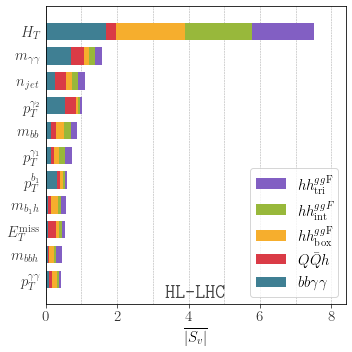

In [5]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}_{\rm box}$', r'$hh^{ggF}_{\rm int}$', r'$hh^{gg\rm F}_{\rm tri}$']
filename = '../results/models/HL-LHC-BDT/hh-BDT-5class-hhsm.pickle.dat'
shap_plot = '../plots/HL-LHC-shap-bbxaa-bbh-tth-hhsm.pdf'

classifier, x_test, y_test, shap_values_5, X_shap_5 = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_5, X_shap_5, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

In [6]:
hhsm_t_p = df_hhsm_t_test.sample(n=round(weight_hhsm_t), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_p = df_hhsm_i_test.sample(n=round(weight_hhsm_i), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_b = df_hhsm_b_test.sample(n=round(weight_hhsm_b), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for hhsm triangle: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm interference: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm box: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_i_b['class'].values, classifier.predict(hhsm_i_b.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for hhsm triangle: 29.91% 
Accuracy Score for hhsm interference: 29.91% 
Accuracy Score for hhsm box: 31.27% 
Accuracy Score for bbh+tth: 70.25% 
Accuracy Score for bbxaa: 89.22% 


In [7]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm_b_test, df_hhsm_i_test, df_hhsm_t_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm_b, weight_hhsm_i, weight_hhsm_t]
keys = ['tri', 'int', 'box', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/HL-LHC-BDT/hh-BDT-5class-hhsm.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,tri,int,box,tth+bbh,bbxaa,Z
tri,28,91,79,175,1825,0.597234
int,14,82,107,99,901,2.364183
box,17,125,257,190,1006,6.435063
tth+bbh,37,176,263,5452,30978,28.379671
bbxaa,10,41,50,1838,287097,534.014052
total,106,515,756,7754,321807,0.000000


### Checks for the confusion matrix

In [8]:
now = time.time()
def func(i):
    df = pd.concat([df_bbxaa_test.sample(n=int(weight_bbxaa), replace=True),
                    df_bbh_tth_test.sample(n=int(weight_bbh_tth)),
                    df_hhsm_b_test.sample(n=int(weight_hhsm_b)), 
                    df_hhsm_i_test.sample(n=int(weight_hhsm_i)), 
                    df_hhsm_t_test.sample(n=int(weight_hhsm_t))])
    true_class = df['class'].values
    predicted_class = classifier.predict(df.iloc[:, :-2].values)
    conf = metrics.confusion_matrix(y_pred=predicted_class, y_true=true_class)[::-1].T
    return conf[4-i][i]/np.sqrt(np.sum(conf[4-i]))

results = Parallel(n_jobs=N_THREADS, backend="loky")(delayed(func)(1) for _ in range(100))
print(time.time() - now, np.mean(results))

98.18621635437012 2.425919994255141


________________________
## The kappa_u & kappa_lambda

In [9]:
channels = [df_ku, df_hhsm_t, df_hhsm_i, df_hhsm_b, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 67.35% 


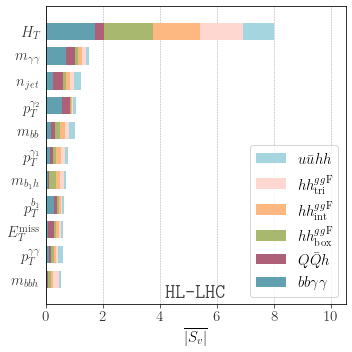

In [10]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}_{\rm box}$', r'$hh^{gg\rm F}_{\rm int}$', r'$hh^{gg\rm F}_{\rm tri}$', r'$u \bar u hh$']
filename = '../results/models/HL-LHC-BDT/hh-BDT-6class-ku.pickle.dat'
shap_plot = '../plots/HL-LHC-shap-bbxaa-bbh-tth-hhsm-ku.pdf'

classifier, x_test, y_test, shap_values_6u, X_shap_6u = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_6u, X_shap_6u, shap_plot, names=names, class_names=class_names, cmp=cmp_6)

In [11]:
ku_p = df_ku_test.sample(n=round(weight_ku), replace=True, random_state=seed).reset_index(drop=True)
hhsm_t_p = df_hhsm_t_test.sample(n=round(weight_hhsm_t), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_p = df_hhsm_i_test.sample(n=round(weight_hhsm_i), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_b = df_hhsm_b_test.sample(n=round(weight_hhsm_b), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(ku_p['class'].values, classifier.predict(ku_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm triangle: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm interference: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm box: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_i_b['class'].values, classifier.predict(hhsm_i_b.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for ku: 24.32% 
Accuracy Score for hhsm triangle: 25.23% 
Accuracy Score for hhsm interference: 25.23% 
Accuracy Score for hhsm box: 27.52% 
Accuracy Score for bbh+tth: 69.43% 
Accuracy Score for bbxaa: 89.33% 


In [12]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm_b_test, df_hhsm_i_test, df_hhsm_t_test, df_ku_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm_b, weight_hhsm_i, weight_hhsm_t, weight_ku]
keys = ['ku', 'tri', 'int', 'box', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/HL-LHC-BDT/hh-BDT-6class-ku.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,ku,tri,int,box,tth+bbh,bbxaa,Z
ku,297,3,22,62,121,654,8.723981
tri,201,26,86,75,166,1659,0.552691
int,106,13,80,103,96,868,2.248398
box,207,16,115,222,155,940,5.457000
tth+bbh,380,36,169,246,5368,30301,28.097396
bbxaa,145,10,41,49,1845,287412,534.169531
total,1336,104,513,757,7751,321834,0.000000


_________________________________
## The kappa_d & kappa_lambda

In [13]:
channels = [df_kd, df_hhsm_t, df_hhsm_i, df_hhsm_b, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 67.57% 


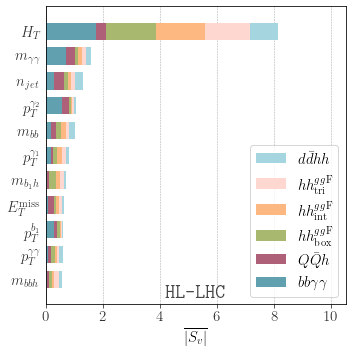

In [14]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}_{\rm box}$', r'$hh^{gg\rm F}_{\rm int}$', r'$hh^{gg\rm F}_{\rm tri}$', r'$d \bar d hh$']
filename = '../results/models/HL-LHC-BDT/hh-BDT-6class-kd.pickle.dat'
shap_plot = '../plots/HL-LHC-shap-bbxaa-bbh-tth-hhsm-kd.pdf'

classifier, x_test, y_test, shap_values_6d, X_shap_6d = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_6d, X_shap_6d, shap_plot, names=names, class_names=class_names, cmp=cmp_6)

In [15]:
kd_p = df_kd_test.sample(n=round(weight_kd), replace=True, random_state=seed).reset_index(drop=True)
hhsm_t_p = df_hhsm_t_test.sample(n=round(weight_hhsm_t), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_p = df_hhsm_i_test.sample(n=round(weight_hhsm_i), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_b = df_hhsm_b_test.sample(n=round(weight_hhsm_b), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(kd_p['class'].values, classifier.predict(kd_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm triangle: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm interference: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm box: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_i_b['class'].values, classifier.predict(hhsm_i_b.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for ku: 22.72% 
Accuracy Score for hhsm triangle: 20.56% 
Accuracy Score for hhsm interference: 20.56% 
Accuracy Score for hhsm box: 27.52% 
Accuracy Score for bbh+tth: 69.69% 
Accuracy Score for bbxaa: 89.17% 


In [16]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm_b_test, df_hhsm_i_test, df_hhsm_t_test, df_kd_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm_b, weight_hhsm_i, weight_hhsm_t, weight_kd]
keys = ['kd', 'tri', 'int', 'box', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/HL-LHC-BDT/hh-BDT-6class-kd.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,kd,tri,int,box,tth+bbh,bbxaa,Z
kd,175,4,25,64,140,816,5.002042
tri,117,25,84,73,156,1533,0.560702
int,68,14,84,109,100,858,2.392201
box,120,16,114,221,150,919,5.631601
tth+bbh,229,37,171,247,5385,30792,28.048016
bbxaa,84,10,40,49,1834,286873,533.732220
total,793,106,518,763,7765,321791,0.000000


________________________
## The kappa_u, kappa_d and kappa_lambda

In [17]:
df_ku['class'] = 6
df_ku_test['class'] = 6
channels = [df_ku, df_kd, df_hhsm_t, df_hhsm_i, df_hhsm_b, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 63.07% 


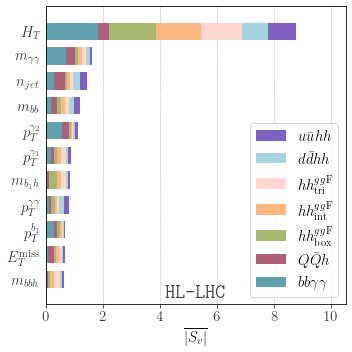

In [18]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}_{\rm box}$', r'$hh^{gg\rm F}_{\rm int}$', r'$hh^{gg\rm F}_{\rm tri}$', r'$d \bar d hh$', r'$u \bar u hh$']
filename = '../results/models/HL-LHC-BDT/hh-BDT-7class-ku-kd.pickle.dat'
shap_plot = '../plots/HL-LHC-shap-bbxaa-bbh-tth-hhsm-ku-kd-kl.pdf'

classifier, x_test, y_test, shap_values_7ud, X_shap_7ud = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_7ud, X_shap_7ud, shap_plot, names=names, class_names=class_names, cmp=cmp_7)

In [19]:
ku_p = df_ku_test.sample(n=round(weight_ku), replace=True, random_state=seed).reset_index(drop=True)
kd_p = df_kd_test.sample(n=round(weight_kd), replace=True, random_state=seed).reset_index(drop=True)
hhsm_t_p = df_hhsm_t_test.sample(n=round(weight_hhsm_t), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_p = df_hhsm_i_test.sample(n=round(weight_hhsm_i), replace=True, random_state=seed).reset_index(drop=True)
hhsm_i_b = df_hhsm_b_test.sample(n=round(weight_hhsm_b), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(ku_p['class'].values, classifier.predict(ku_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for kd: {:4.2f}% '.format(100*metrics.accuracy_score(kd_p['class'].values, classifier.predict(kd_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm triangle: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm interference: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_t_p['class'].values, classifier.predict(hhsm_t_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm box: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_i_b['class'].values, classifier.predict(hhsm_i_b.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for ku: 14.84% 
Accuracy Score for kd: 12.61% 
Accuracy Score for hhsm triangle: 24.30% 
Accuracy Score for hhsm interference: 24.30% 
Accuracy Score for hhsm box: 27.00% 
Accuracy Score for bbh+tth: 69.27% 
Accuracy Score for bbxaa: 89.15% 


In [20]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm_b_test, df_hhsm_i_test, df_hhsm_t_test, df_kd_test, df_ku_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm_b, weight_hhsm_i, weight_hhsm_t, weight_kd, weight_ku]
keys = ['ku', 'kd', 'tri', 'int', 'box', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/HL-LHC-BDT/hh-BDT-7class-ku-kd.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,ku,kd,tri,int,box,tth+bbh,bbxaa,Z
ku,181,101,2,13,37,75,469,6.108454
kd,168,96,4,18,41,95,624,2.968284
tri,195,119,26,88,78,157,1457,0.564684
int,105,65,13,80,106,88,782,2.272764
box,190,110,15,109,208,145,923,5.044741
tth+bbh,371,220,36,170,245,5388,30683,27.968203
bbxaa,141,83,10,40,47,1812,286870,533.622285
total,1351,794,106,518,762,7760,321808,0.000000


_____________________________
## Standard Model di-Higgs

In [21]:
channels = [df_hhsm, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 83.45% 


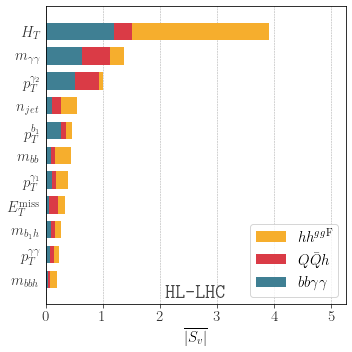

In [22]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}$']
filename = '../results/models/HL-LHC-BDT/hh-BDT-3class-hhsm-SM.pickle.dat'
shap_plot = '../plots/HL-LHC-shap-bbxaa-bbh-tth-hhsm-SM.pdf'

classifier, x_test, y_test, shap_values_3, X_shap_3 = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_3, X_shap_3, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

In [23]:
hhsm_p = df_hhsm_test.sample(n=round(weight_hhsm), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_p['class'].values, classifier.predict(hhsm_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for hhsm: 38.20% 
Accuracy Score for bbh+tth: 73.70% 
Accuracy Score for bbxaa: 89.55% 


In [24]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm]
keys = ['hhsm', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/HL-LHC-BDT/hh-BDT-3class-hhsm-SM.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,hhsm,tth+bbh,bbxaa,Z
hhsm,142,183,1290,3.533475
tth+bbh,177,5712,32338,29.214812
bbxaa,34,1861,288150,535.039607
total,353,7756,321778,0.000000


### Checks for the confusion matrix

In [25]:
now = time.time()
def func(i):
    df = pd.concat([df_bbxaa_test.sample(n=int(weight_bbxaa), replace=True), df_bbh_tth_test.sample(n=int(weight_bbh_tth)), df_hhsm.sample(n=int(weight_hhsm))])
    true_class = df['class'].values
    predicted_class = classifier.predict(df.iloc[:, :-2].values)
    conf = metrics.confusion_matrix(y_pred=predicted_class, y_true=true_class)[::-1].T
    return conf[2][0]/np.sqrt(np.sum(conf[2]))

results = Parallel(n_jobs=N_THREADS, backend="loky")(delayed(func)(1) for _ in range(500))
print(time.time() - now, np.mean(results))

186.54820227622986 4.772608539390341
